# **5. Spatial Transformer Networks Tutorial**

Spatial Transformer Networks란?

미분 가능한 어텐션 메커니즘을 임의의 공간 변환으로 일반화한 개념

이 네트워크는 입력 이미지에 대해 공간적 변환을 학습하고 수행함으로써 모델의 기하학적 변화에 대한 불변성을 향상 시켜줌

STN은 다음과 같은 작업을 할 수 있음

1. 이미지에서 중요한 영역을 자동으로 잘라내기 (crop)

2. 크기(scale)를 조절하거나 방향(orientation)을 바로잡기

3. 회전이나 비율 왜곡 같은 affine transformation에 대응

STN의 가장 큰 장점은 기존의 CNN 구조에 거의 수정없이 손쉽게 통합 할 수 있다는 것

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

# Loading the data

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=',', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # 평균과 표준표차로 정규화
                   ])), batch_size=64, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=',', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Depicting spatial transformer networks

STN은 세가지 주요 구성요소로 이루어짐

1. Localization Network (위치 결정 네트워크)

- 일반적인 CNN 구조로 구성되어있음
- 이 네트워크는 공간 변환(Spatial Transformation)에 필요한 파라미터(이동, 회전, 크기조정)를 예측
- 이 변환이 데이터셋으로부터 직접 주어지지 않음
- 대신 네트워크는 전체 정확도를 높일 수 있는 변환을 자동으로 학습

2. Grid Generator (격자 생성기)

- 출력이미지의 각 픽셀에 대해 입력 이미지에서 어느 좌표를 참조할지 결정하는 좌표 격자를 생성함
- 변환된 공간의 픽셀 위치가 원본 이미지의 어디를 참조해야 하는지 정의

3. Sampler (샘플러)

- 변환 파라미터를 받아 해당 좌표를 기준으로 입력 이미지에 변환을 적용
- 이 과정에서 실제 이미지 픽셀 값을 보간하여 새로운 출력 이미지 생성

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # 기본적인 CNN 구조
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

    # STN - Localization Network 구성
    self.localization = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=7),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(8, 10, kernel_size=5),
        nn.MaxPool2d(2, stride =2),
        nn.ReLU(True)
    )

    # localization 의 출력을 flatten하고 아핀 변환 파라터 예측
    self.fc_loc = nn.Sequential(
        nn.Linear(10 * 3 * 3, 32),
        nn.ReLU(True),
        nn.Linear(32, 3 * 2)
    )

    # 초기에 변환 없이 그대로 출력되도록 단위 변환 행렬로 설정 (2 x 3의 단위행렬)
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  def stn(self, x):
    xs = self.localization(x) # CNN으로 특징 추출
    xs = xs.view(-1, 10 * 3 * 3) # flatten
    theta = self.fc_loc(xs) # affine 파라미터 예측
    theta = theta.view(-1, 2, 3)

    grid = F.affine_grid(theta, x.size()) # 아핀 변환 좌표 격자 생성
    x = F.grid_sample(x, grid) # 변환된 자푶로 이미지 보간 적용

    return x

  def forward(self, x):
    # STN으로 입력 이미지 변환 (회전, 이동, 보간)
    x = self.stn(x)

    # 일반 CNN 으로 분류
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

model = Net().to(device)

# Training the model

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01) # optimizer 정의

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    # 학습 블록
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 500 == 0: # 500번째 배치마다 로그 출력
      print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx*len(data),len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0

    # 한 배치씩 모델에 입력해 출력 계산
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      # 배치 손실을 전부 더함
      test_loss += F.nll_loss(output, target, size_average = False).item()

      # output에서 가장 높은 확률의 클래스 인덱스를 예측으로
      pred = output.max(1, keepdim=True)[1]

      # 예측값과 실제값이 같은 개수를 누적해 정확도 계산
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
    .format(test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

# Visualizing the STN results

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5082: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train epoch: 1 [0/60000 (0%)]	Loss: 2.333586
Train epoch: 1 [32000/60000 (53%)]	Loss: 0.944433


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2273, Accuracy: 9387/10000 (94%)

Train epoch: 2 [0/60000 (0%)]	Loss: 0.400911
Train epoch: 2 [32000/60000 (53%)]	Loss: 0.362946

Test set: Average loss: 0.1270, Accuracy: 9625/10000 (96%)

Train epoch: 3 [0/60000 (0%)]	Loss: 0.305964
Train epoch: 3 [32000/60000 (53%)]	Loss: 0.403332

Test set: Average loss: 0.1090, Accuracy: 9663/10000 (97%)

Train epoch: 4 [0/60000 (0%)]	Loss: 0.373349
Train epoch: 4 [32000/60000 (53%)]	Loss: 0.342989

Test set: Average loss: 0.0923, Accuracy: 9718/10000 (97%)

Train epoch: 5 [0/60000 (0%)]	Loss: 0.165454
Train epoch: 5 [32000/60000 (53%)]	Loss: 0.407784

Test set: Average loss: 0.0810, Accuracy: 9764/10000 (98%)

Train epoch: 6 [0/60000 (0%)]	Loss: 0.123069
Train epoch: 6 [32000/60000 (53%)]	Loss: 0.098073

Test set: Average loss: 0.0810, Accuracy: 9737/10000 (97%)

Train epoch: 7 [0/60000 (0%)]	Loss: 0.187630
Train epoch: 7 [32000/60000 (53%)]	Loss: 0.198323

Test set: Average loss: 0.0754, Accuracy: 9771/10000 (98%)

Tra

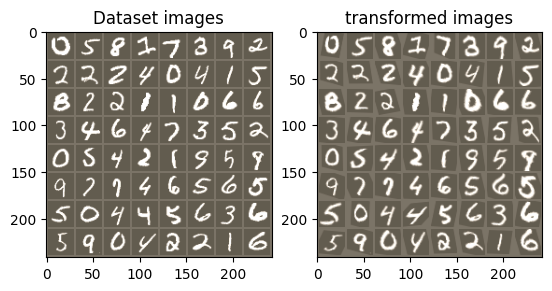

In [ ]:
# 시각화 가능한 이미지로 변환
def convert_image_np(inp):
  inp = inp.numpy().transpose((1, 2, 0)) # 시각화를 위해 C, H, W -> H, W, C
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

# STN 변환 결과를 시각화
def visualize_stn():
  with torch.no_grad():
    data = next(iter(test_loader))[0].to(device) # 배치 하나만 꺼냄
    input_tensor = data.cpu()
    transformed_input_tensor = model.stn(data).cpu() # cpu로 옮겨야 matplotlib으로 시각화 가능

    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('transformed images')

for epoch in range(1, 20 + 1):
  train(epoch)
  test()

visualize_stn()

plt.ioff()
plt.show()